# Artificial Neural Networks and Deep Learning

---

## Lecture 7b: Timeseries Forecasting

<img src="https://drive.google.com/uc?export=view&id=1Co7J09_1WY1kmurHm8SJPkxZw2_5s_tL" width="500"/>

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Lecture 6

## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [3]:
# Set environment variables for Air Quality dataset
os.environ["DATASET_NAME"] = "air_quality.csv"
os.environ["DATASET_URL"] = "1RQZbTbSsj-rL2Xc960VRge4cDmV0ByNf"

# Check if Air Quality dataset exists, download and unzip if not
if not os.path.exists(os.environ["DATASET_NAME"]):
    print("Downloading Air Quality dataset...")
    !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
    print("Air Quality dataset downloaded!")
else:
    print("Air Quality dataset already downloaded. Using cached data.")

Air Quality dataset downloaded!


In [4]:
# Load the dataset from a CSV file
dataset = pd.read_csv('air_quality.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset.shape}")

# Display the first few rows of the dataset
dataset.head()

Dataset shape: (43800, 3)


,dew,temperature,pression
0,-16,-4.0,1020.0
1,-15,-4.0,1020.0
2,-11,-5.0,1021.0
3,-7,-5.0,1022.0
4,-7,-5.0,1022.0


In [5]:
# Display a summary of the dataset's structure and data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          43800 non-null  int64  
 1   temperature  43800 non-null  float64
 2   pression     43800 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.0 MB


In [6]:
# Convert 'dew' column to float32
dataset['dew'] = dataset['dew'].astype(np.float32)

# Convert 'temperature' column to float32
dataset['temperature'] = dataset['temperature'].astype(np.float32)

# Convert 'pression' column to float32
dataset['pression'] = dataset['pression'].astype(np.float32)

# Display updated dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          43800 non-null  float32
 1   temperature  43800 non-null  float32
 2   pression     43800 non-null  float32
dtypes: float32(3)
memory usage: 513.4 KB


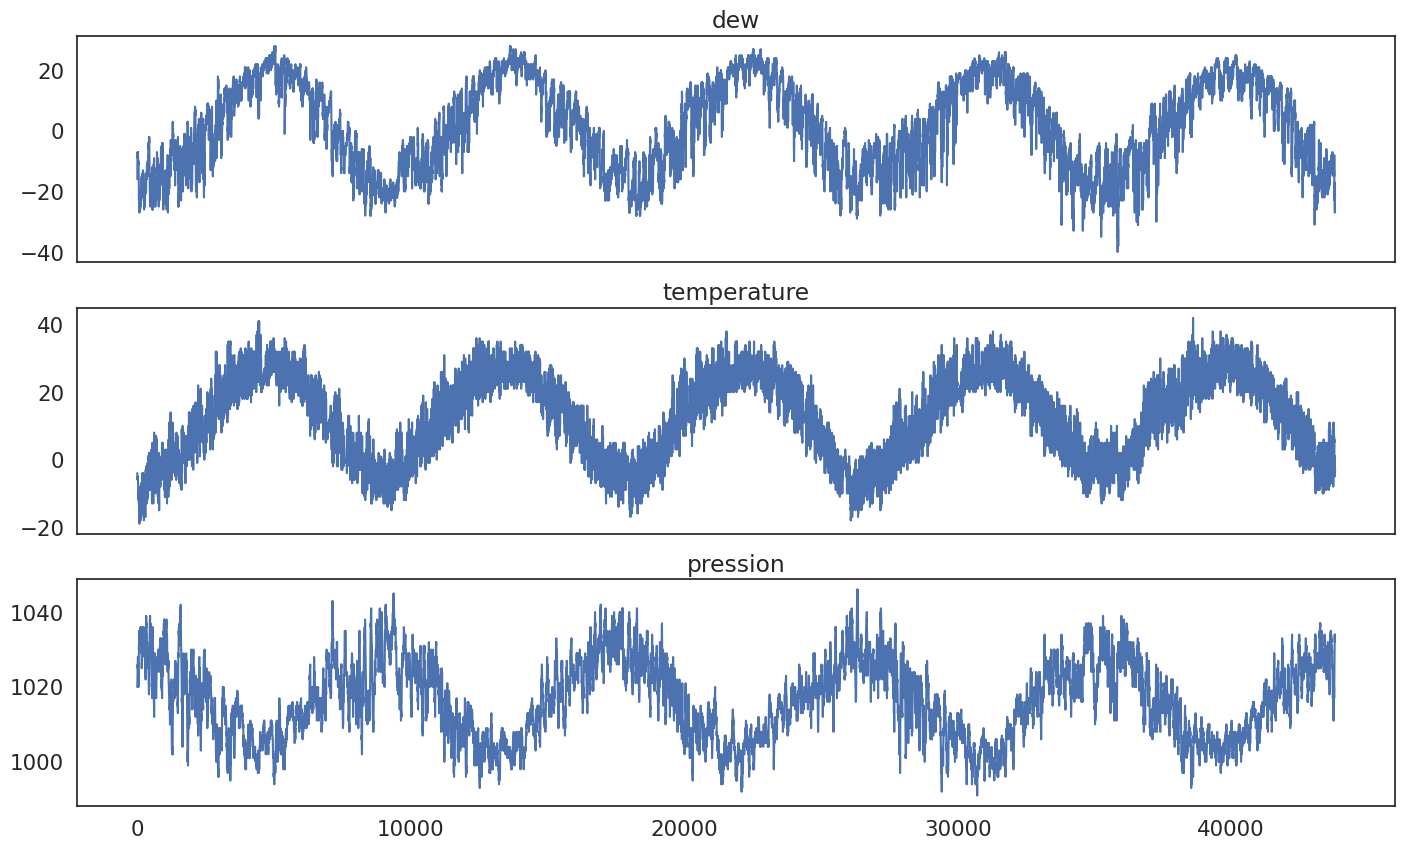

In [7]:
# Define a function to plot and inspect specified columns of a dataframe
def inspect_dataframe(df, columns):
    # Create subplots for each column
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through the specified columns and plot each
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)

    # Display the plots
    plt.show()

# Call the function to inspect all columns of the dataset
inspect_dataframe(dataset, dataset.columns)

In [8]:
# Define sizes for validation and test sets
val_size = 2850
test_size = 2850

# Split the dataset into training, validation, and test sets
X_train_raw = dataset.iloc[:-val_size-test_size]
X_val_raw = dataset.iloc[-val_size-test_size:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# Print the shapes of the split datasets
print(f"Train set shape: {X_train_raw.shape}")
print(f"Validation set shape: {X_val_raw.shape}")
print(f"Test set shape: {X_test_raw.shape}")

# Normalise data using training set statistics
X_min = X_train_raw.min()
X_max = X_train_raw.max()

# Apply min-max normalisation
X_train_raw = (X_train_raw - X_min) / (X_max - X_min)
X_val_raw = (X_val_raw - X_min) / (X_max - X_min)
X_test_raw = (X_test_raw - X_min) / (X_max - X_min)

Train set shape: (38100, 3)
Validation set shape: (2850, 3)
Test set shape: (2850, 3)


In [9]:


# Define target labels as the column names of the dataset
target_labels = dataset.columns

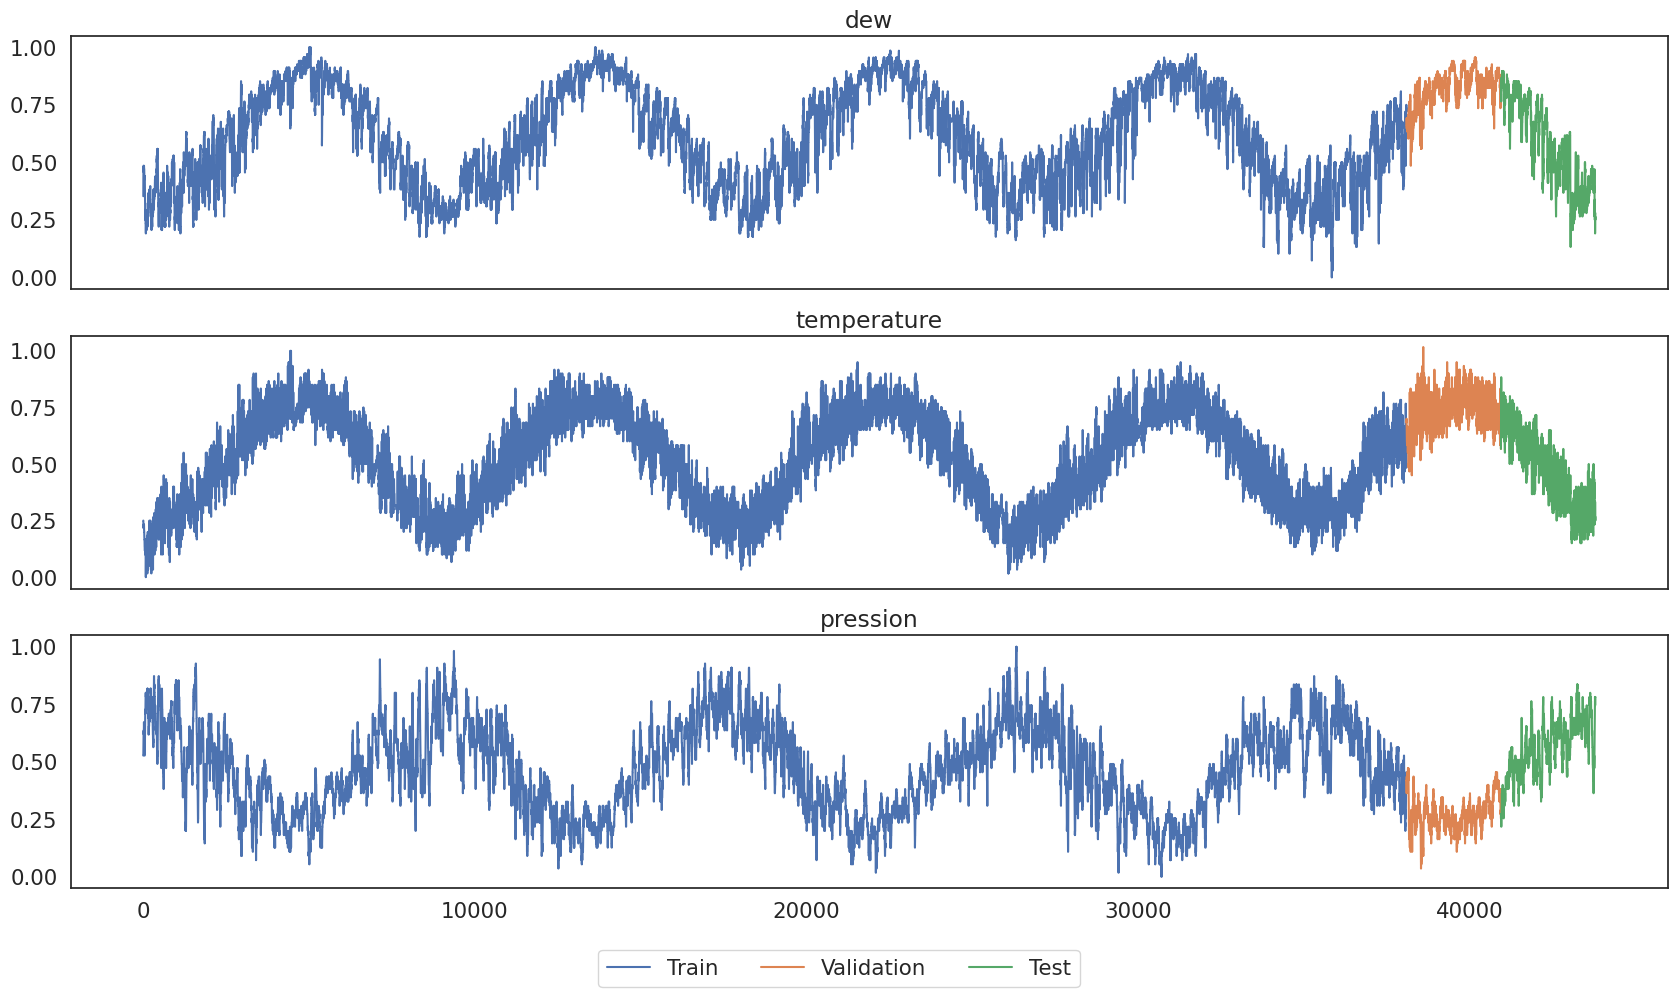

In [10]:
# Define a function to inspect and compare data splits
def inspect_splits(X_train, X_val, X_test, columns):
    # Create subplots for each column
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Plot train, validation, and test data for each column
    for i, col in enumerate(columns):
        axs[i].plot(X_train[col], label='Train')
        axs[i].plot(X_val[col], label='Validation')
        axs[i].plot(X_test[col], label='Test')
        axs[i].set_title(col)

    # Add a single legend below all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    figs.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.02),
                ncol=3, borderaxespad=0.)

    # Adjust layout to prevent legend overlap
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

# Inspect splits across all target labels
inspect_splits(X_train_raw, X_val_raw, X_test_raw, target_labels)

In [11]:
# Define window size for time-series data
window = 50

# Define stride length for window movement
stride = 5

# Define telescope size for prediction horizon
telescope = 50

In [12]:
# Extract the last 'window' rows of the dataset for future prediction
future = dataset[-window:]

# Normalise the future data using training set statistics
future = (future - X_min) / (X_max - X_min)

# Expand dimensions to prepare for model input
future = np.expand_dims(future, axis=0)

# Print the shape of the prepared future data
future.shape

(1, 50, 3)

In [13]:
# Define a function to build sequences and corresponding labels from a dataframe
def build_sequences(df, target_labels=['temperature'], window=200, stride=20, telescope=100):
    # Ensure the window size is compatible with the stride
    assert window % stride == 0

    # Initialise containers for dataset sequences and labels
    dataset = []
    labels = []

    # Copy dataframe values for processing
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values

    # Check for and handle padding requirement
    padding_check = len(df) % window
    if padding_check != 0:
        # Compute padding length
        padding_len = window - len(df) % window

        # Add zero-padding to features and labels
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding, temp_df))

        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding, temp_label))

        # Verify that the padded data length is divisible by the window size
        assert len(temp_df) % window == 0

    # Create sequences and corresponding labels
    for idx in np.arange(0, len(temp_df) - window - telescope, stride):
        dataset.append(temp_df[idx:idx + window])
        labels.append(temp_label[idx + window:idx + window + telescope])

    # Convert lists to numpy arrays
    dataset = np.array(dataset)
    labels = np.array(labels)

    # Return the dataset and labels
    return dataset, labels

## 🛠️ Multivariate Forecating (Direct)

In [14]:
# Define direct telescope size for prediction horizon
direct_telescope = telescope

In [15]:
# Build sequences and labels for training, validation, and test datasets
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, direct_telescope)
X_val, y_val = build_sequences(X_val_raw, target_labels, window, stride, direct_telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, direct_telescope)

# Print the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7600, 50, 3),
 (7600, 50, 3),
 (550, 50, 3),
 (550, 50, 3),
 (550, 50, 3),
 (550, 50, 3))

In [16]:
# Define a function to inspect multivariate sequences and predictions
def inspect_multivariate(X, y, columns, telescope, idx=None):
    # Select a random index if none is provided
    if idx is None:
        idx = np.random.randint(0, len(X))

    # Create subplots for visualisation
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through each column and plot the sequence and target predictions
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0, :, i]), len(X[0, :, i]) + telescope),
                       y[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)

    # Display the plots
    plt.show()

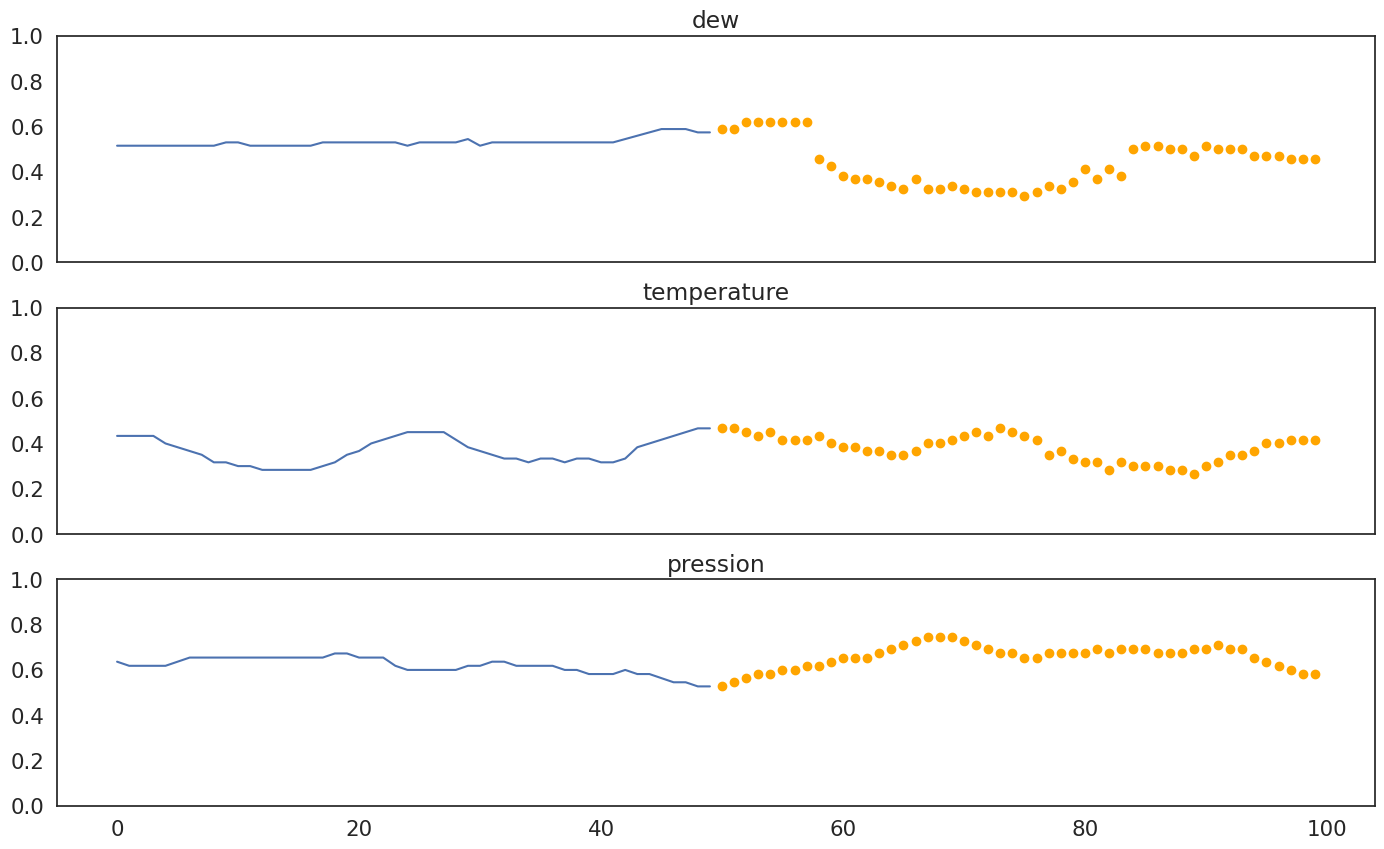

In [17]:
# Inspect multivariate sequences and predictions using the training data
inspect_multivariate(X_train, y_train, target_labels, direct_telescope)

In [18]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the output shape based on the training labels
output_shape = y_train.shape[1:]

# Set the batch size for training
batch_size = 64

# Set the number of epochs for training
epochs = 200

In [19]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a first LSTM layer with 128 units
    x = tfkl.LSTM(128, return_sequences=True, name='lstm1')(input_layer)
    x = tfkl.Dropout(0.3)(x)

    # Add a second LSTM layer with 128 units
    x = tfkl.LSTM(128, return_sequences=True, name='lstm2')(x)
    x = tfkl.Dropout(0.3)(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', name='conv1')(x)
    x = tfkl.Activation('relu', name='relu_after_conv1')(x)
    x = tfkl.Dropout(0.3)(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='relu_after_conv2')(x)
    x = tfkl.Dropout(0.3)(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    return model

Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 50, 3)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm1 (LSTM)                        │ (None, 50, 128)              │        67,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm2 (LSTM)                        │ (None, 50, 128)              │       131,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv1D)                      │ (None, 50, 128)              │        49,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu_after_conv1 (Activation)       │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv1D)                      │ (None, 50, 128)              │        49,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu_after_conv2 (Activation)       │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_3 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ output_layer (Conv1D)               │ (None, 50, 3)                │         1,155 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cropping (Cropping1D)               │ (None, 50, 3)                │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 298,883 (1.14 MB)

 Trainable params: 298,883 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

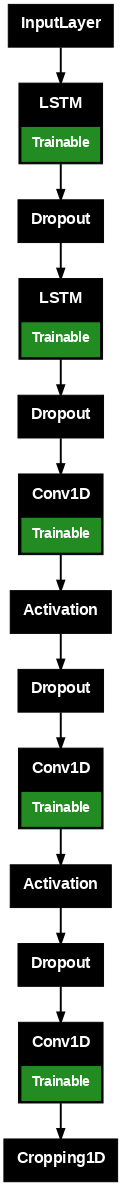

In [20]:
# Build the ConvLSTM model using the specified input and output shapes
model = build_CONV_LSTM_model(input_shape, output_shape)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [21]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation mse
final_val_mse = round(min(history['val_loss']), 4)
print(f'Final validation MSE: {final_val_mse}')

# Save the trained model to a file with the mse included in the filename
model_filename = 'DirectForecaster_'+str(final_val_mse)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0680 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0145 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0123 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0113 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0106 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0101 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0098 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0097 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 9/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0095 - val_loss: 0.0066 - learning_rate

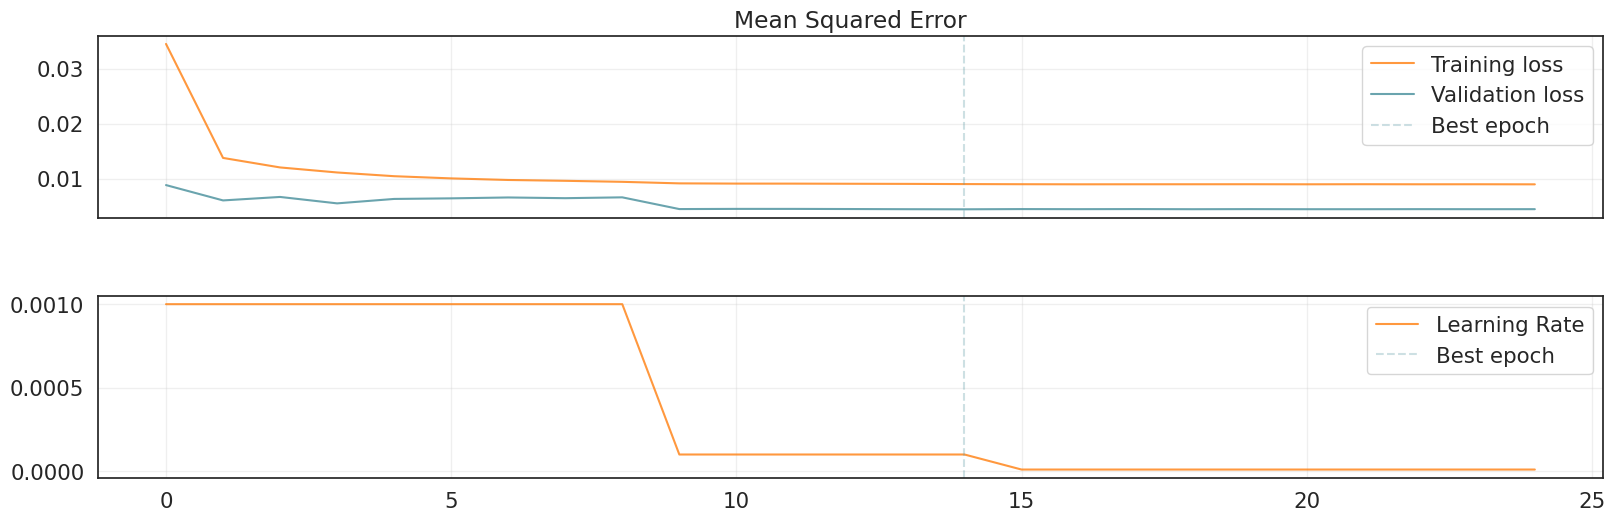

In [25]:
best_epoch = np.argmin(history['val_loss'])

# Create figure with 2 subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 6), sharex=True)
fig.tight_layout(pad=3.0)

# First subplot: Loss curves
ax1.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
ax1.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
ax1.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
ax1.set_title('Mean Squared Error')
ax1.legend()
ax1.grid(alpha=.3)

# Second subplot: Learning rate
ax2.plot(history['learning_rate'], label='Learning Rate', alpha=.8, color='#ff7f0e')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
ax2.legend()
ax2.grid(alpha=.3)

plt.show()

## 🕹️ Use the Model - Make Inference

In [26]:
# model.save('DirectForecasting')
model = tfk.models.load_model('DirectForecaster_0.0045.keras')

In [27]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.losses.MSE(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.losses.MAE(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (550, 50, 3)
Mean Squared Error: 0.007956454530358315
Mean Absolute Error: 0.06923440098762512


In [28]:
# Define a function to inspect multivariate predictions versus ground truth
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    # Select a random index if none is provided
    if idx is None:
        idx = np.random.randint(0, len(X))

    # Prepare prediction and ground truth by concatenating the last known point
    pred = np.concatenate([np.expand_dims(X[:, -1, :], axis=1), pred], axis=1)
    y = np.concatenate([np.expand_dims(X[:, -1, :], axis=1), y], axis=1)

    # Create subplots for visualisation
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through each column and plot actual, true, and predicted values
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])  # Plot historical data
        axs[i].plot(np.arange(len(X[0, :, i]) - 1, len(X[0, :, i]) + telescope),
                    y[idx, :, i], color='orange', label='Ground Truth')  # Plot ground truth
        axs[i].plot(np.arange(len(X[0, :, i]) - 1, len(X[0, :, i]) + telescope),
                    pred[idx, :, i], color='green', label='Prediction')  # Plot predictions
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)

    # Display the plots
    plt.show()

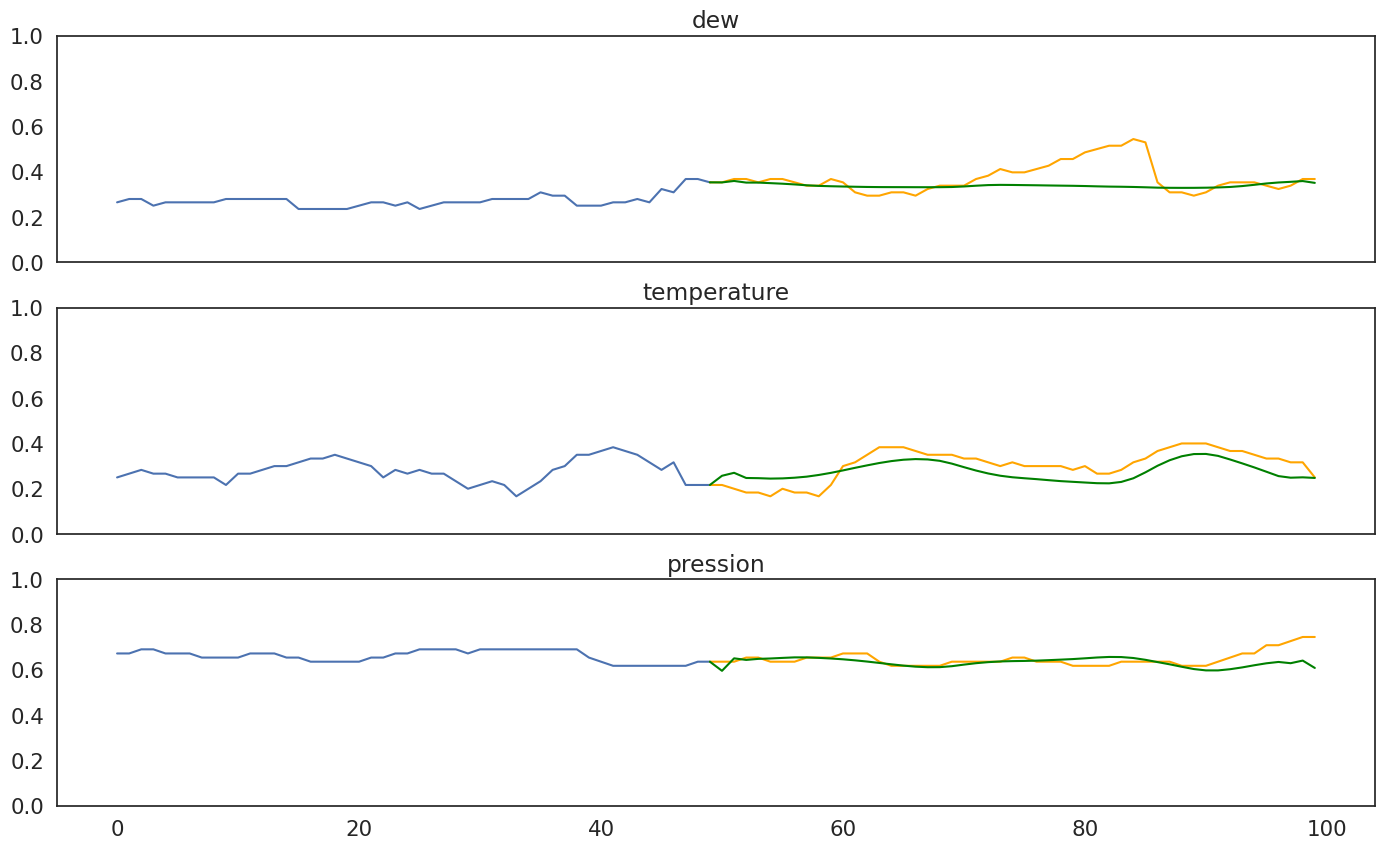

In [29]:
# Inspect multivariate predictions versus ground truth using the test data
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, direct_telescope)

#### 🔮 Predict the future!

In [30]:
# Compute Mean Absolute Errors (MAEs) for each feature and prediction step
maes = []

# Loop over each timestep in the predictions
for i in range(predictions.shape[1]):
    ft_maes = []

    # Loop over each feature in the predictions
    for j in range(predictions.shape[2]):
        # Calculate MAE for the current feature and timestep
        ft_maes.append(np.mean(np.abs(y_test[:, i, j] - predictions[:, i, j]), axis=0))

    # Convert feature MAEs to a numpy array and append to overall MAEs
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)

# Convert MAEs to a numpy array
maes = np.array(maes)

In [31]:
# Generate predictions for future data using the trained model
future_predictions = model.predict(future, verbose=0)

# Concatenate the last known point of the future data with the predictions
future_predictions = np.concatenate([np.expand_dims(future[:, -1, :], axis=0), future_predictions], axis=1)

# Append zeros to the beginning of the MAEs array for alignment
maes = np.concatenate([np.array([[0, 0, 0]]), maes], axis=0)

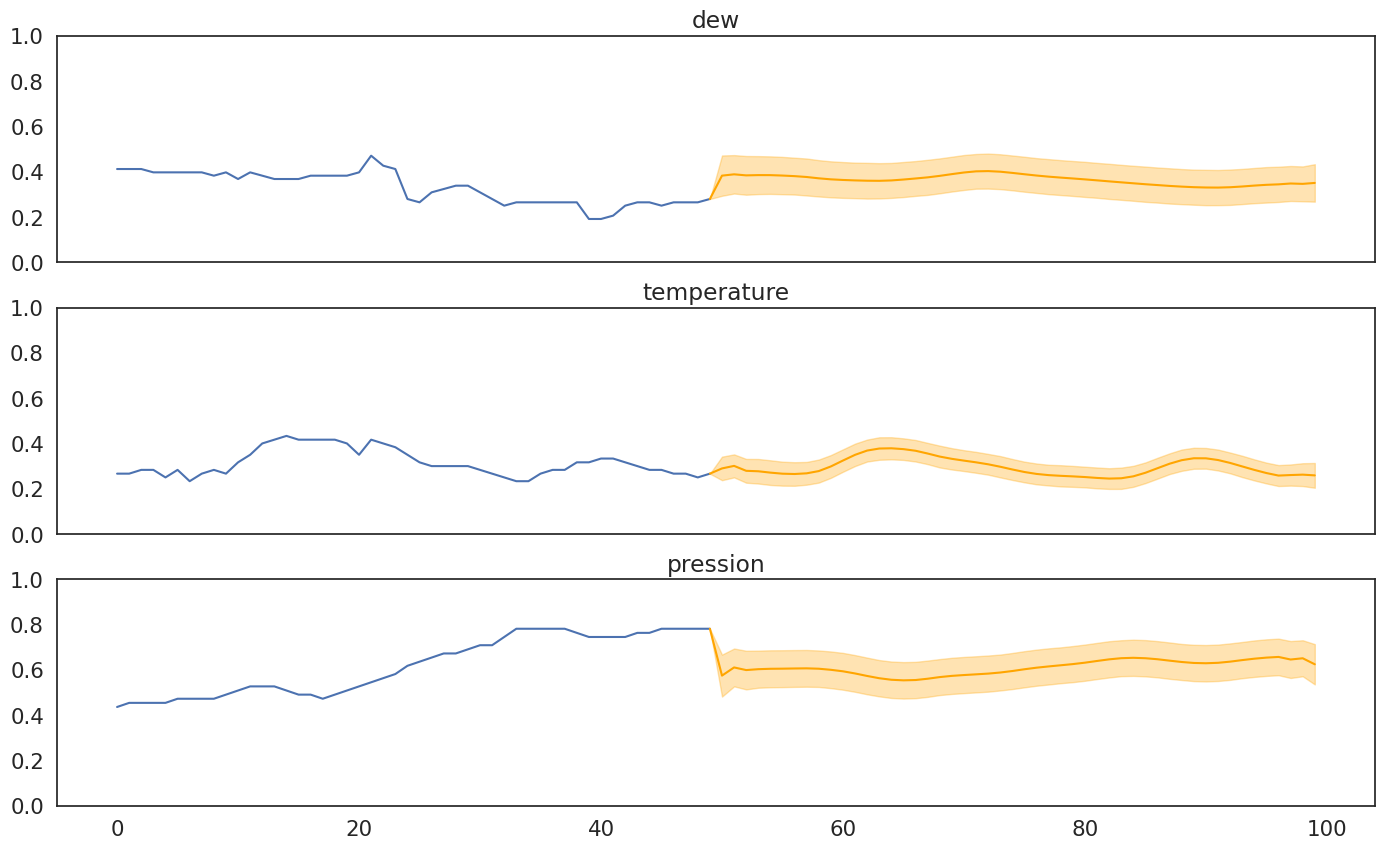

In [32]:
# Create subplots for visualising future predictions with uncertainty
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17, 10))

# Loop over each target label to plot predictions and uncertainty
for i, col in enumerate(target_labels):
    # Plot the historical future data
    axs[i].plot(np.arange(len(future[0, :, i])), future[0, :, i])

    # Plot the future predictions
    axs[i].plot(np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
                future_predictions[0, :, i], color='orange')

    # Fill the area between MAE bounds to visualise uncertainty
    axs[i].fill_between(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i] + maes[:, i],
        future_predictions[0, :, i] - maes[:, i],
        color='orange', alpha=0.3
    )

    # Set title and limits for the subplot
    axs[i].set_title(col)
    axs[i].set_ylim(0, 1)

# Display the plot
plt.show()

## 🛠️ Multivariate Forecating (Autoregressive)

In [33]:
# Define the autoregressive telescope size for predictions
autoregressive_telescope = 10

# Ensure the autoregressive telescope size is less than the original telescope size
assert autoregressive_telescope < telescope

In [34]:
# Rebuild sequences and labels for training, validation, and test datasets using the autoregressive telescope
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, autoregressive_telescope)
X_val, y_val = build_sequences(X_val_raw, target_labels, window, stride, autoregressive_telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, autoregressive_telescope)

# Print the shapes of the newly created datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7608, 50, 3),
 (7608, 10, 3),
 (558, 50, 3),
 (558, 10, 3),
 (558, 50, 3),
 (558, 10, 3))

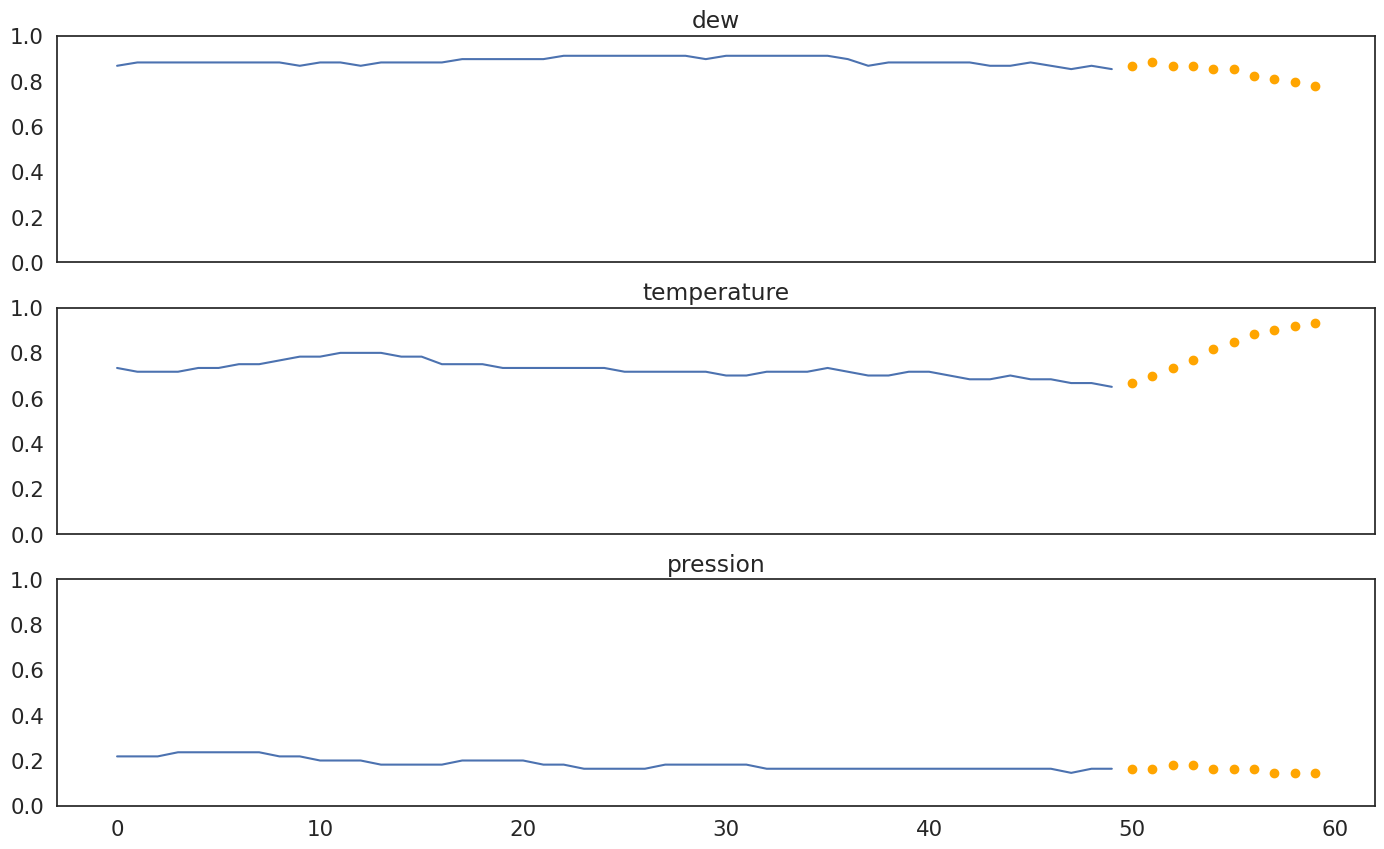

In [35]:

# Inspect multivariate sequences and corresponding labels using the autoregressive telescope
inspect_multivariate(X_train, y_train, target_labels, autoregressive_telescope)

In [36]:
# Define the input shape based on the autoregressive training data
input_shape = X_train.shape[1:]

# Define the output shape based on the autoregressive training labels
output_shape = y_train.shape[1:]

# Set the batch size for training
batch_size = 64

# Set the number of epochs for training
epochs = 200

Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 50, 3)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm1 (LSTM)                        │ (None, 50, 128)              │        67,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_4 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lstm2 (LSTM)                        │ (None, 50, 128)              │       131,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_5 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv1D)                      │ (None, 50, 128)              │        49,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu_after_conv1 (Activation)       │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_6 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv1D)                      │ (None, 50, 128)              │        49,280 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu_after_conv2 (Activation)       │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_7 (Dropout)                 │ (None, 50, 128)              │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ output_layer (Conv1D)               │ (None, 50, 3)                │         1,155 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cropping (Cropping1D)               │ (None, 10, 3)                │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 298,883 (1.14 MB)

 Trainable params: 298,883 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

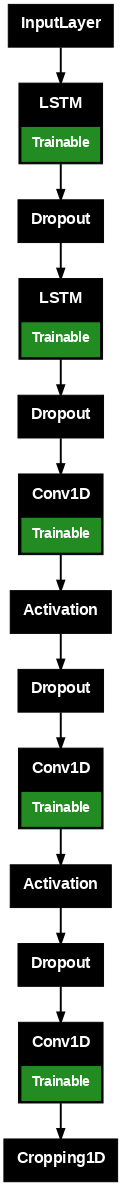

In [37]:
# Build the ConvLSTM model using the specified input and output shapes for the autoregressive task
model = build_CONV_LSTM_model(input_shape, output_shape)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [38]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_mse = round(min(history['val_loss']), 4)
print(f'Final validation MSE: {final_val_mse}')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'AutoregressiveForecaster_'+str(final_val_mse)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0848 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0145 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0128 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0117 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0112 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0107 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0105 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0103 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 9/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0100 - val_loss: 0.0051 - learning_rate:

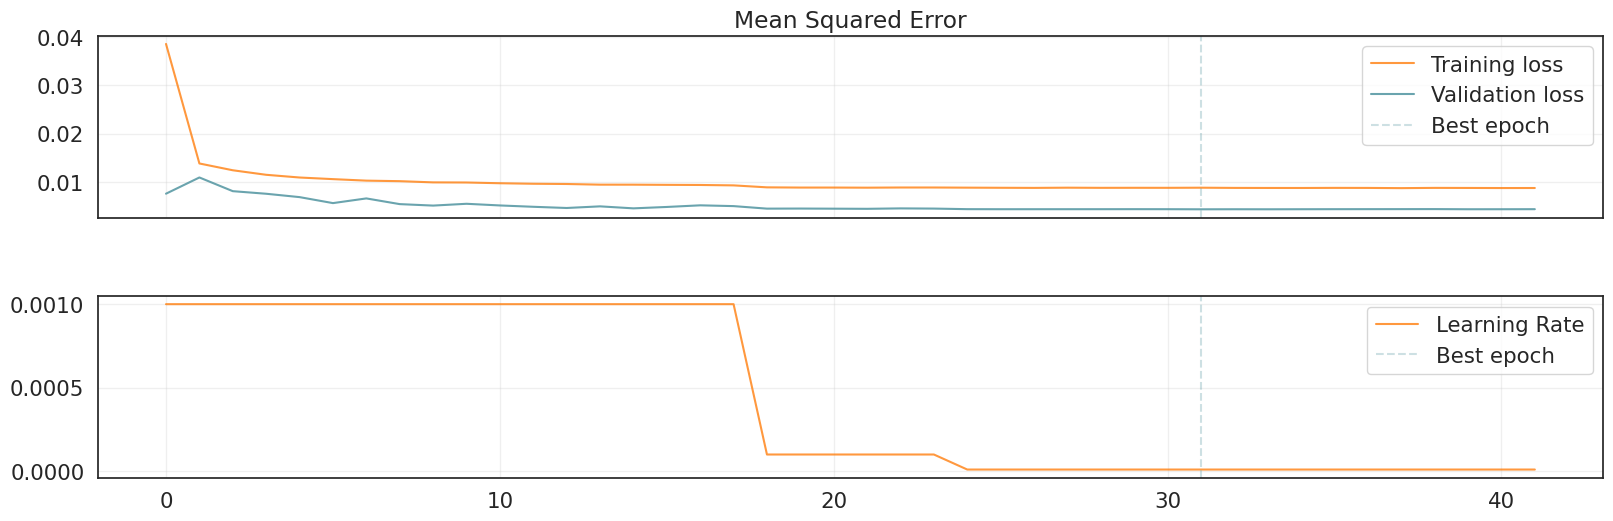

In [39]:
best_epoch = np.argmin(history['val_loss'])

# Create figure with 2 subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 6), sharex=True)
fig.tight_layout(pad=3.0)

# First subplot: Loss curves
ax1.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
ax1.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
ax1.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
ax1.set_title('Mean Squared Error')
ax1.legend()
ax1.grid(alpha=.3)

# Second subplot: Learning rate
ax2.plot(history['learning_rate'], label='Learning Rate', alpha=.8, color='#ff7f0e')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
ax2.legend()
ax2.grid(alpha=.3)

plt.show()

## 🕹️ Use the Model - Make Inference

In [41]:
# model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AutoregressiveForecaster_0.0043.keras')

In [42]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.losses.MSE(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.losses.MAE(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (558, 10, 3)
Mean Squared Error: 0.00831435527652502
Mean Absolute Error: 0.07009493559598923


In [43]:
# Build sequences and labels for the test dataset using the full telescope size
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, telescope)

# Print the shapes of the test dataset sequences and labels
X_test_reg.shape, y_test_reg.shape

((550, 50, 3), (550, 50, 3))

In [44]:
# Perform autoregressive forecasting
reg_predictions = np.array([])  # Initialise an empty array to store predictions
X_temp = X_test_reg  # Temporary variable to store input data for autoregressive steps

# Iterate through the telescope in steps of the autoregressive telescope size
for reg in range(0, telescope, autoregressive_telescope):
    # Predict the next set of values using the model
    pred_temp = model.predict(X_temp, verbose=0)

    # Concatenate predictions to the overall results
    if len(reg_predictions) == 0:
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions, pred_temp), axis=1)

    # Update the input data for the next prediction step by appending the predictions
    X_temp = np.concatenate((X_temp[:, autoregressive_telescope:, :], pred_temp), axis=1)

In [45]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.losses.MSE(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.losses.MSE(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (550, 50, 3)
Mean Squared Error: 0.008318977430462837
Mean Absolute Error: 0.008318977430462837


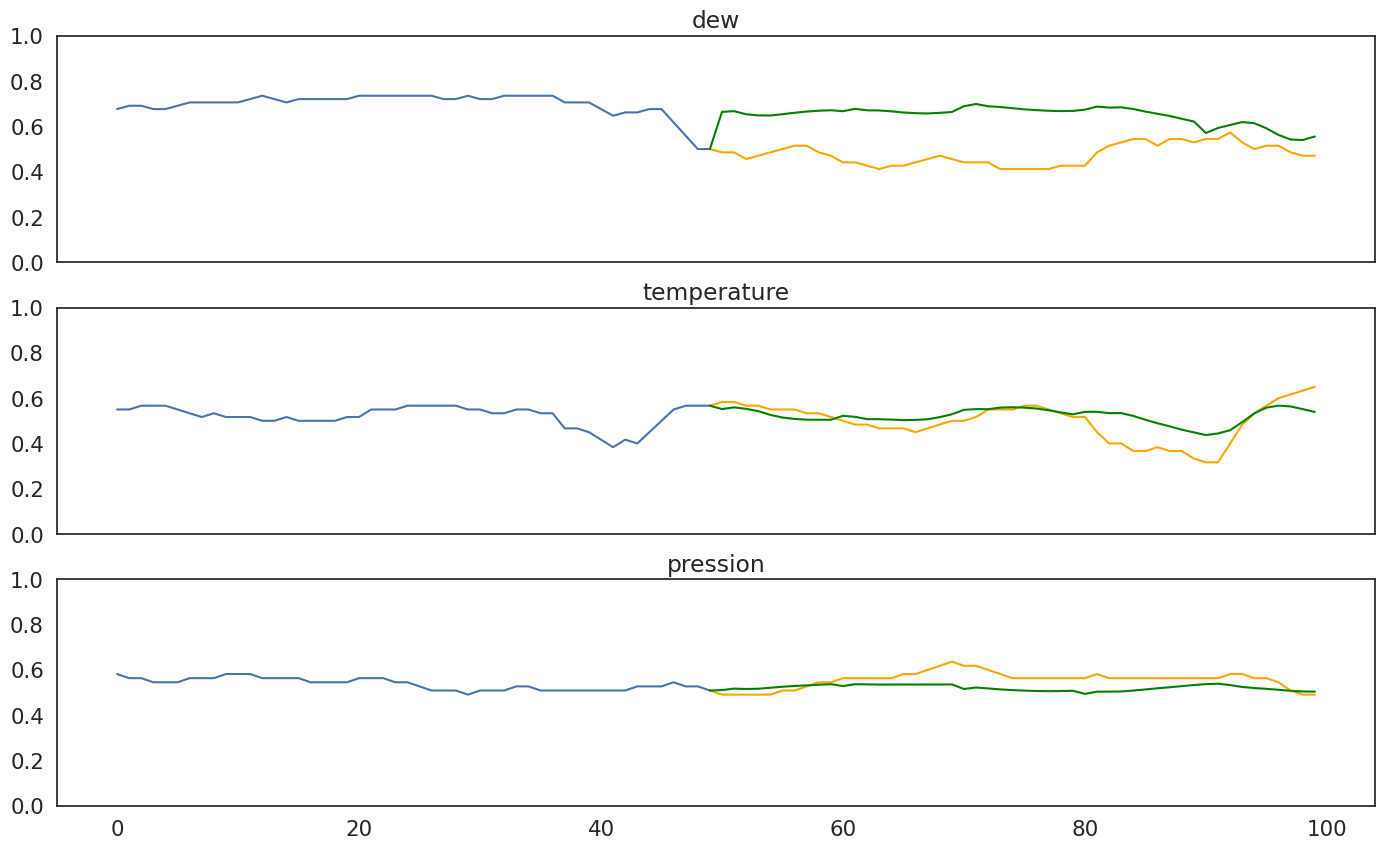

In [46]:
# Inspect multivariate predictions versus ground truth using the autoregressive forecasting results
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, telescope)

#### 🔮 Predict the future!

In [47]:
# Compute Mean Absolute Errors (MAEs) for each feature and prediction step in autoregressive forecasting
maes = []

# Loop over each timestep in the autoregressive predictions
for i in range(reg_predictions.shape[1]):
    ft_maes = []

    # Loop over each feature in the predictions
    for j in range(reg_predictions.shape[2]):
        # Calculate MAE for the current feature and timestep
        ft_maes.append(np.mean(np.abs(y_test_reg[:, i, j] - reg_predictions[:, i, j]), axis=0))

    # Convert feature MAEs to a numpy array and append to overall MAEs
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)

# Convert MAEs to a numpy array
maes = np.array(maes)

In [48]:
# Perform autoregressive forecasting for future predictions
reg_future = np.array([])  # Initialise an empty array to store future predictions
X_temp = future  # Set the initial input sequence for forecasting

# Iterate through the telescope in steps of the autoregressive telescope size
for reg in range(0, telescope, autoregressive_telescope):
    # Predict the next set of values using the model
    pred_temp = model.predict(X_temp, verbose=0)

    # Concatenate predictions to the overall future forecasting results
    if len(reg_future) == 0:
        reg_future = pred_temp  # Initialise the future predictions
    else:
        reg_future = np.concatenate((reg_future, pred_temp), axis=1)  # Append new predictions

    # Update the input data for the next prediction step
    X_temp = np.concatenate((X_temp[:, autoregressive_telescope:, :], pred_temp), axis=1)

In [49]:
# Concatenate the last known point of the future data with the autoregressive future predictions
reg_future = np.concatenate([np.expand_dims(future[:, -1, :], axis=0), reg_future], axis=1)

# Append zeros to the beginning of the MAEs array for alignment with the future predictions
maes = np.concatenate([np.array([[0, 0, 0]]), maes], axis=0)

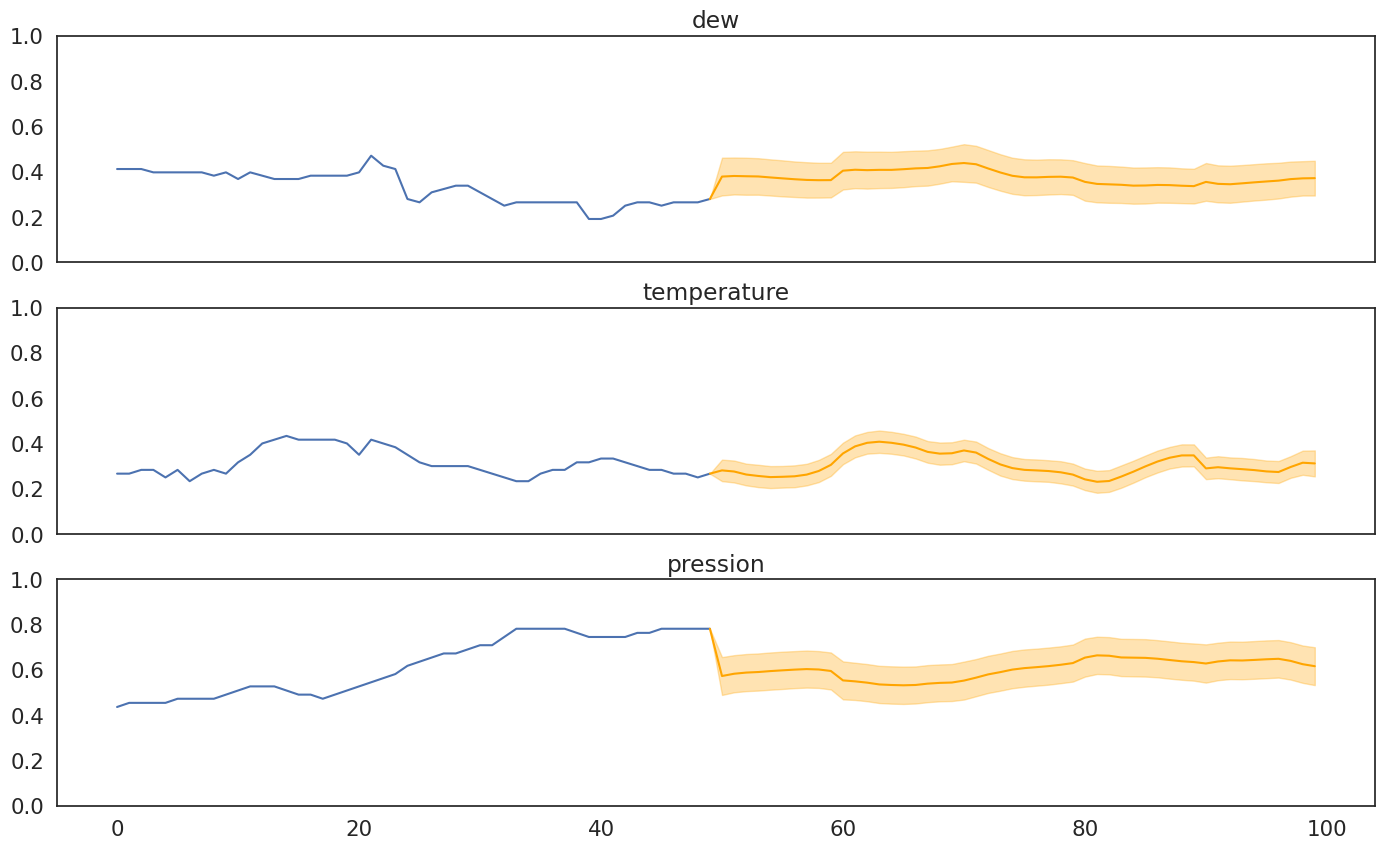

In [50]:
# Create subplots for visualising future autoregressive predictions with uncertainty
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17, 10))

# Loop over each target label to plot predictions and uncertainty
for i, col in enumerate(target_labels):
    # Plot the historical future data
    axs[i].plot(np.arange(len(future[0, :, i])), future[0, :, i])

    # Plot the autoregressive future predictions
    axs[i].plot(np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + telescope),
                reg_future[0, :, i], color='orange')

    # Fill the area between MAE bounds to visualise uncertainty
    axs[i].fill_between(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + telescope),
        reg_future[0, :, i] + maes[:, i],
        reg_future[0, :, i] - maes[:, i],
        color='orange', alpha=0.3
    )

    # Set title and limits for the subplot
    axs[i].set_title(col)
    axs[i].set_ylim(0, 1)

# Display the plot
plt.show()

<img src="https://drive.google.com/uc?export=view&id=1gWxnQ1RkH9j9zX_iPUcG4cP_MOfo7PgR" width="700"/>